## Figure 2: Characterization of macrophage populations in non-IPF and IPF bronchoalveolar lavage

In [1]:
library(Seurat)       
library(Matrix)       
library(RColorBrewer) 
library(pheatmap) 
library(ggplot2)
set.seed(1) 

options(repr.plot.width = 25, repr.plot.height = 15)
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
# Load Seurat Object
bal <- readRDS("BAL_FINAL.rds")
macs <- subset(bal, Cell_Type == "Macrophage")

## Figure 2a: Heatmap of top differentially expressed genes within BAL macrophages in non-IPF versus IPF patients

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


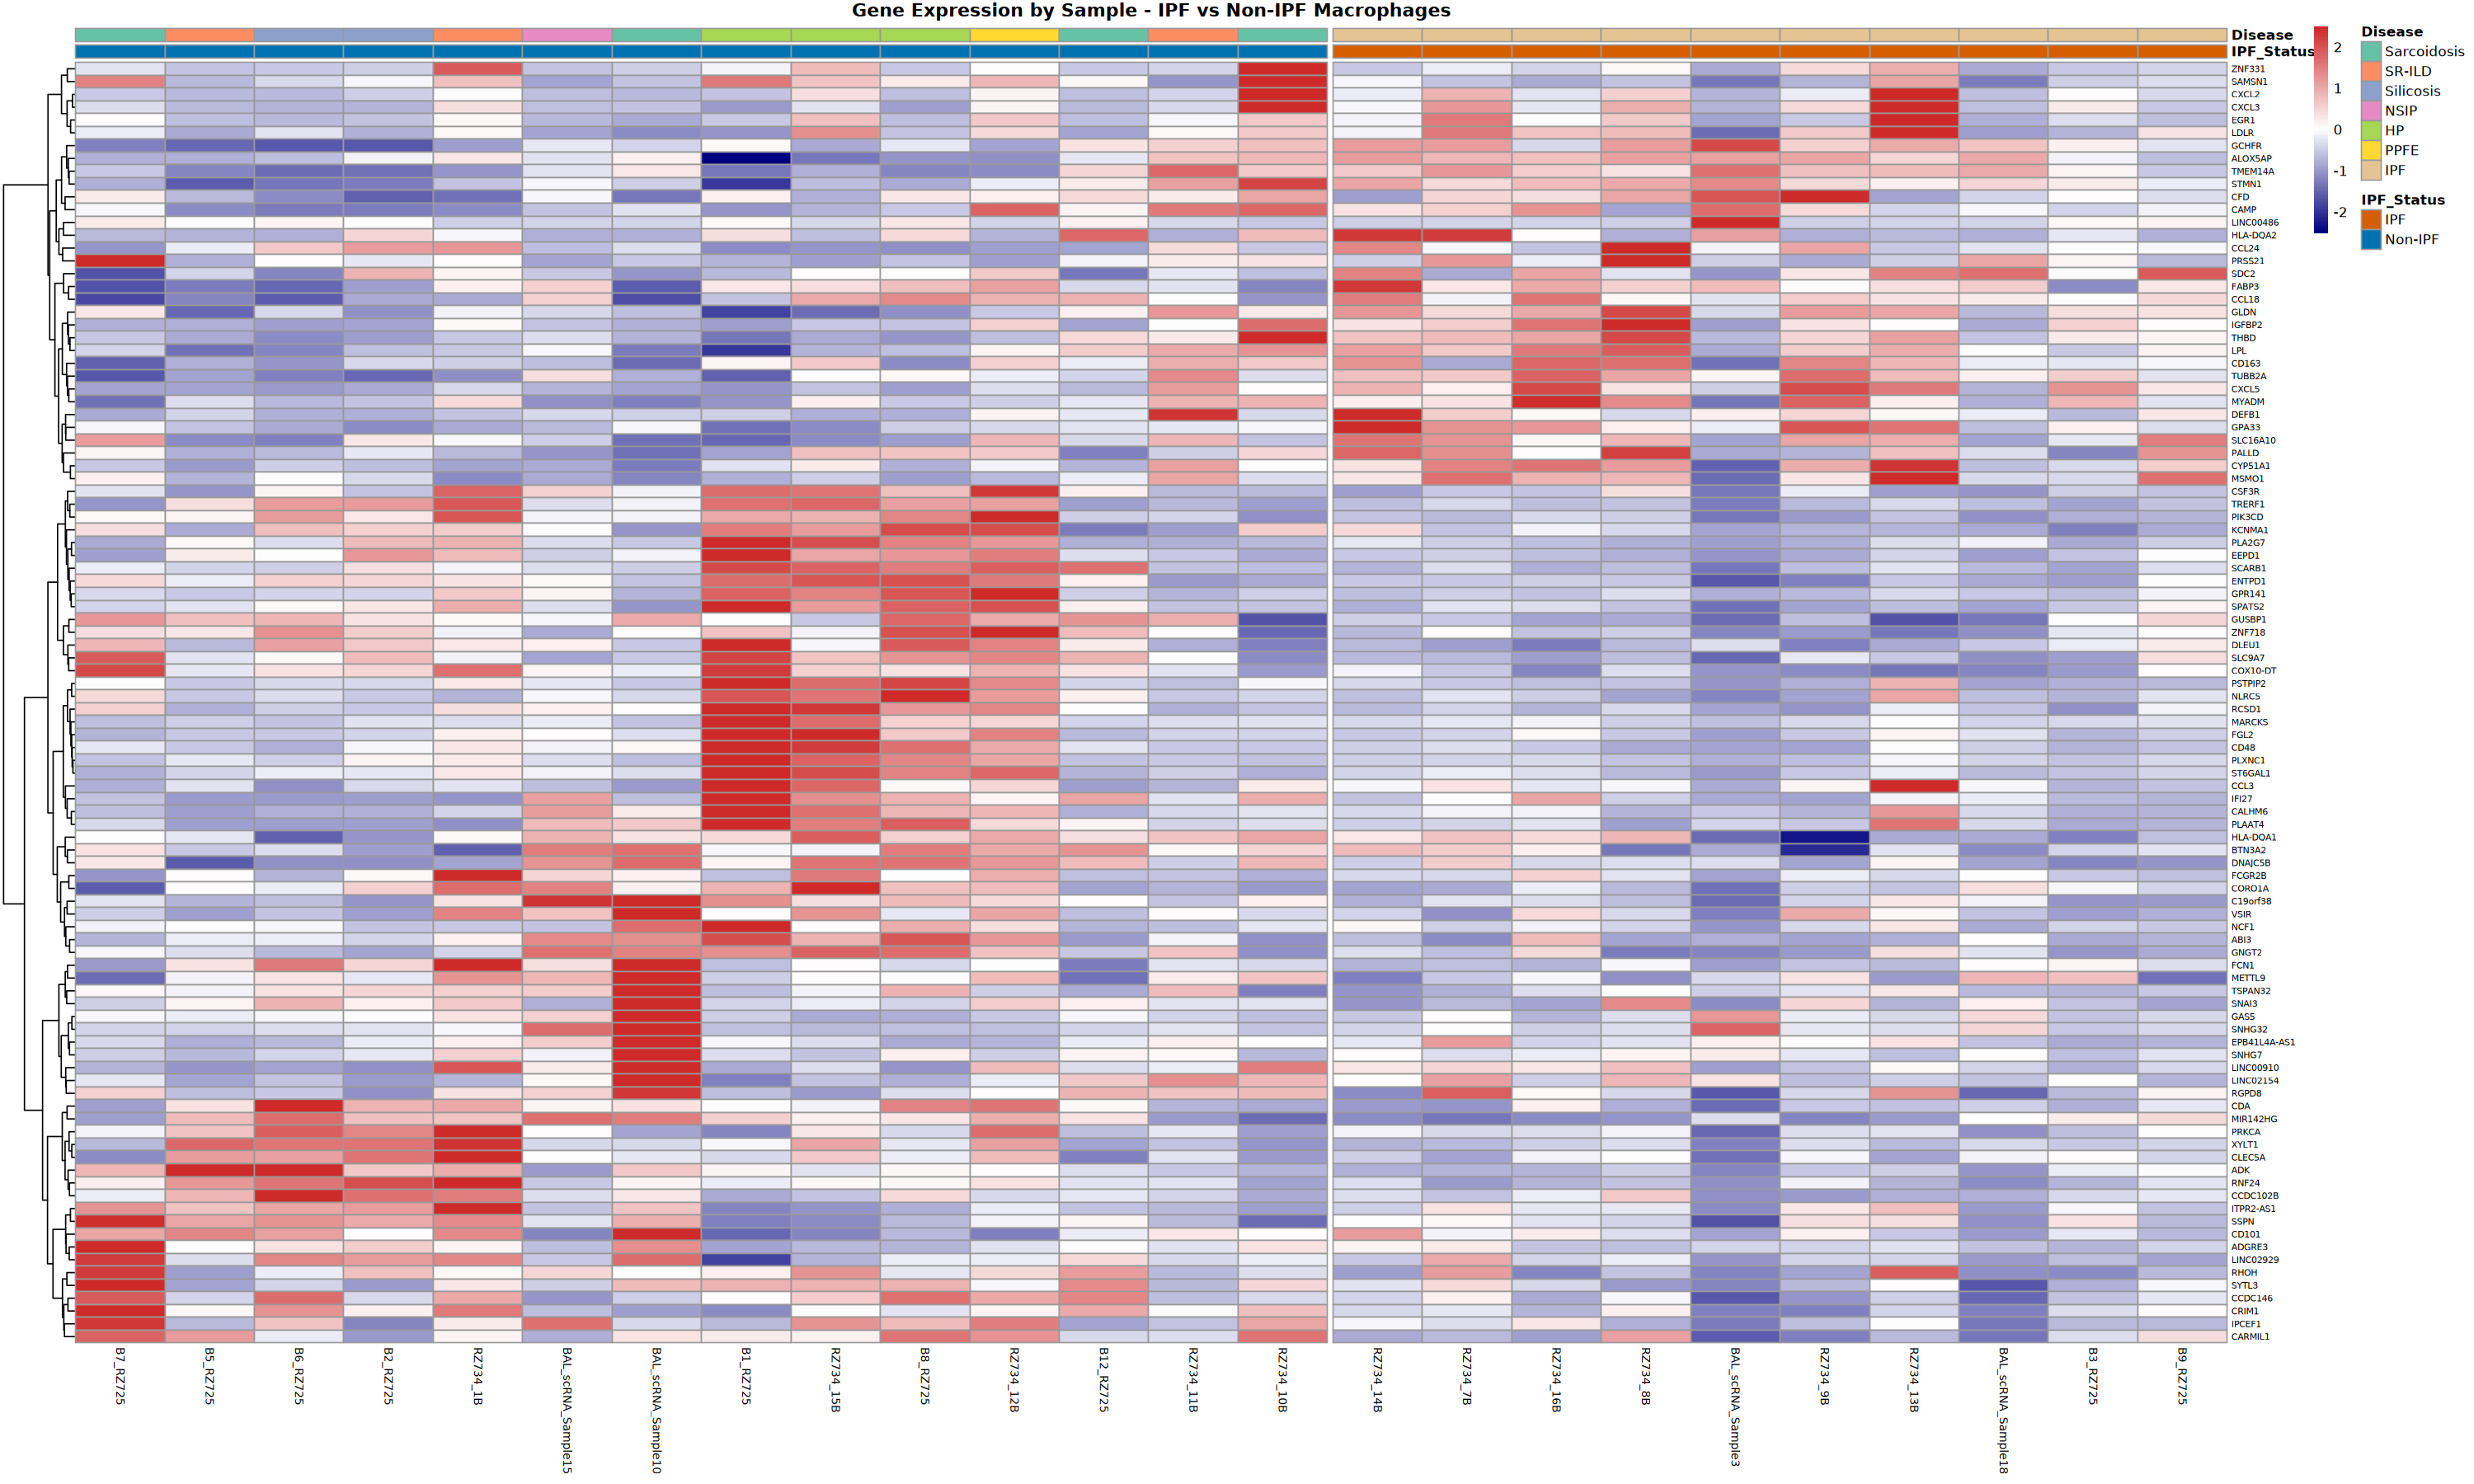

In [ ]:
# Set cell identities to IPF status
Idents(macs) <- macs@meta.data$IPF

# Run Seurat's differential expression analysis
de_results <- FindMarkers(
  macs,
  ident.1 = "IPF",
  ident.2 = "Non-IPF",
  min.pct = 0.1,
  logfc.threshold = 0,
  test.use = "wilcox",
  max.cells.per.ident = 5000,
  verbose = FALSE
)

# Sort by absolute log fold change
de_results$abs_avg_logFC <- abs(de_results$avg_log2FC)
de_results <- de_results[order(de_results$abs_avg_logFC, decreasing = TRUE),]

# Filter out genes starting with "ENSG"
de_genes_filtered <- rownames(de_results)[!grepl("^ENSG", rownames(de_results))]

# Get top 100 genes 
variable_genes <- de_genes_filtered[1:min(100, length(de_genes_filtered))]
expr_matrix <- GetAssayData(macs, slot = "data")[variable_genes, ]

metadata <- macs@meta.data
sample_info <- unique(metadata[, c("Sample", "IPF")])
rownames(sample_info) <- sample_info$Sample

samples <- unique(metadata$Sample)
nonipf_samples <- samples[sample_info[samples, "IPF"] == "Non-IPF"]

# Create a matrix to store the average expression for each sample
avg_expr <- matrix(0, nrow = length(variable_genes), ncol = length(samples))
rownames(avg_expr) <- variable_genes
colnames(avg_expr) <- samples

# Calculate average expression for each sample
for(sample_name in samples) {
  cell_indices <- which(metadata$Sample == sample_name)
  if(length(cell_indices) > 0) {
    avg_expr[, sample_name] <- rowMeans(expr_matrix[, cell_indices, drop = FALSE])
  }
}

# Get IPF status for each sample
sample_ipf <- setNames(sample_info$IPF, sample_info$Sample)

# Specified sample ordering
# List of non-IPF samples in the desired order
nonipf_ordered <- c("B7_RZ725", "B5_RZ725", "B6_RZ725", "B2_RZ725", "RZ734_1B", 
                   "BAL_scRNA_Sample15", "BAL_scRNA_Sample10", "B1_RZ725", 
                   "RZ734_15B", "B8_RZ725", "RZ734_12B", "B12_RZ725", 
                   "RZ734_11B", "RZ734_10B")

# List of IPF samples in the desired order
ipf_ordered <- c("RZ734_14B", "RZ734_7B", "RZ734_16B", "RZ734_8B", "BAL_scRNA_Sample3", 
                "RZ734_9B", "RZ734_13B", "BAL_scRNA_Sample18", "B3_RZ725", "B9_RZ725")

ordered_samples <- c(nonipf_ordered, ipf_ordered)

# Reorder the expression matrix columns
avg_expr <- avg_expr[, ordered_samples]

# Scale each gene individually
avg_expr_scaled <- t(scale(t(avg_expr), center = TRUE, scale = TRUE))

# Cap extreme values
avg_expr_scaled[avg_expr_scaled > 2.5] <- 2.5
avg_expr_scaled[avg_expr_scaled < -2.5] <- -2.5

# Create annotation for the heatmap columns
column_annotation <- adata.frame(
  IPF_Status = sample_ipf[colnames(avg_expr)],
  row.names = colnames(avg_expr)
)

# Add disease_final annotation 
if("disease_final" %in% colnames(metadata)) {
  disease_vector <- character(length(ordered_samples))
  names(disease_vector) <- ordered_samples
  
  for(sample_name in ordered_samples) {
    # Find cells for this sample
    sample_cells <- which(metadata$Sample == sample_name)
    if(length(sample_cells) > 0) {
      # Get the most common disease_final value
      disease_values <- as.character(metadata$disease_final[sample_cells])
      disease_table <- table(disease_values)
      disease_vector[sample_name] <- names(which.max(disease_table))
    }
  }
  
  # Add to annotation
  column_annotation$Disease <- disease_vector
  
  # Create disease colors
  disease_types <- unique(disease_vector[!is.na(disease_vector)])
  n_diseases <- length(disease_types)
  
  disease_colors <- setNames(
    colorRampPalette(brewer.pal(min(9, n_diseases), "Set2"))(n_diseases),
    disease_types
  )
  
  # Define colors for annotations
  ipf_colors <- c("IPF" = "#D55E00", "Non-IPF" = "#0072B2")
  ann_colors <- list(
    IPF_Status = ipf_colors,
    Disease = disease_colors
  )
} else {
  ipf_colors <- c("IPF" = "#D55E00", "Non-IPF" = "#0072B2")
  ann_colors <- list(IPF_Status = ipf_colors)
}

# Find gap position between IPF and non-IPF
ipf_gap <- sum(ordered_samples %in% nonipf_ordered)

# Generate the heatmap
p <- pheatmap(
  avg_expr_scaled,
  annotation_col = column_annotation,
  annotation_colors = ann_colors,
  show_colnames = TRUE,
  cluster_cols = FALSE,
  cluster_rows = TRUE,
  clustering_method = "ward.D2",
  fontsize_row = 6,
  fontsize_col = 8,
  main = "Gene Expression by Sample - IPF vs Non-IPF Macrophages",
  gaps_col = ipf_gap,
  color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
  breaks = seq(-2.5, 2.5, length.out = 100)
)

## Figure 2b: UMAP of monocyte-like macrophage subclusters

/jobfs/160799686.gadi-pbs/ipykernel_269256/1455260446.py:23: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['myeloid_subtype'] = adata.obs['Cell_Subtype']


Series([], Name: count, dtype: int64)


/jobfs/160799686.gadi-pbs/ipykernel_269256/1455260446.py:62: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['myeloid_subtype'] = adata.obs['myeloid_subtype'].astype('category')


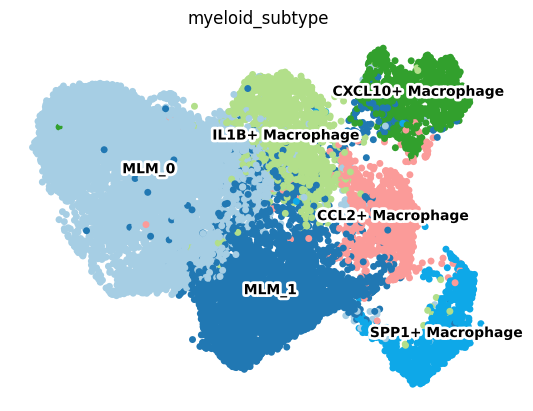

<Figure size 640x480 with 0 Axes>

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt


# Import adata
adata = sc.read('data/BAL_FINAL.h5ad')

# Plot MLM subplot
mdm_meta = pd.read_csv('data/mlm_cluster_metadata.csv', index_col=0)
mdm_umap = pd.read_csv('data/mlm_umap_embeddings.csv', index_col=0)

# Merge adata.obs with cell_meta by their indices
adata.obs = adata.obs.join(mdm_meta[['mdm_clusters']], rsuffix='_cell_meta')

# Isolate celltypes of interest
celltypes = ['Alveolar macrophage', 'Monocyte-like macrophage', 'Proliferating alveolar macrophage', 'Interstitial-like macrophage']
adata = adata[adata.obs['Cell_Subtype'].isin(celltypes)]

# Initialize the subtype column
adata.obs['myeloid_subtype'] = adata.obs['Cell_Subtype']

# Convert mdm_clusters to integer
adata.obs['mdm_clusters'] = pd.to_numeric(adata.obs['mdm_clusters'], errors='coerce').dropna().astype(int)

# Assign Cell_Sub_subtype based on mdm_clusters values
adata.obs['myeloid_subtype'] = adata.obs['mdm_clusters'].map({
    0: 'MLM_0',
    1: 'MLM_1',
    2: 'IL1B+ Macrophage',
    3: 'CXCL10+ Macrophage',
    4: 'CCL2+ Macrophage',
    5: 'SPP1+ Macrophage'
}).fillna(adata.obs['myeloid_subtype'])

# Replace the UMAP coordinates in data with those from mdm_umap
# Align indices of mdm_umap with adata.obs
aligned_umap = mdm_umap.reindex(adata.obs.index)
adata.obsm['X_umap'] = aligned_umap[['umap_1', 'umap_2']].values

# Count the values of adata.obs['myeloid_subtype'] that have NaN in their adata.obsm['X_umap']
nan_umap_counts = adata.obs.loc[aligned_umap.isna().any(axis=1), 'myeloid_subtype'].value_counts()
print(nan_umap_counts)

# Remove cells with NaN in adata.obsm['X_umap']
adata = adata[~aligned_umap.isna().any(axis=1)]

# Define custom colors for specific myeloid_subtype to match trajectory
custom_colors = {
    'MLM_0': '#a6cee4',
    'MLM_1': '#2178b3',
    'IL1B+ Macrophage': '#b2df8a',
    'CXCL10+ Macrophage': '#32a02d',
    'CCL2+ Macrophage': '#fb9b99',
    'SPP1+ Macrophage': '#0ea8e8'
}

# Assign the custom colors to the adata.uns
# Ensure 'myeloid_subtype' is of categorical dtype
adata.obs['myeloid_subtype'] = adata.obs['myeloid_subtype'].astype('category')

adata.uns['myeloid_subtype_colors'] = [custom_colors.get(subtype, '#333333') for subtype in adata.obs['myeloid_subtype'].cat.categories]

sc.pl.umap(adata, color='myeloid_subtype', save=False, frameon=False, legend_loc='on data', title=None, size=100, legend_fontsize='10', legend_fontoutline=4)

plt.tight_layout()
# plt.savefig('figures/umap_high_resSubtype.png', dpi=300)


## Figure 2c: Dotplot of top genes expressed by each macrophage subcluster

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


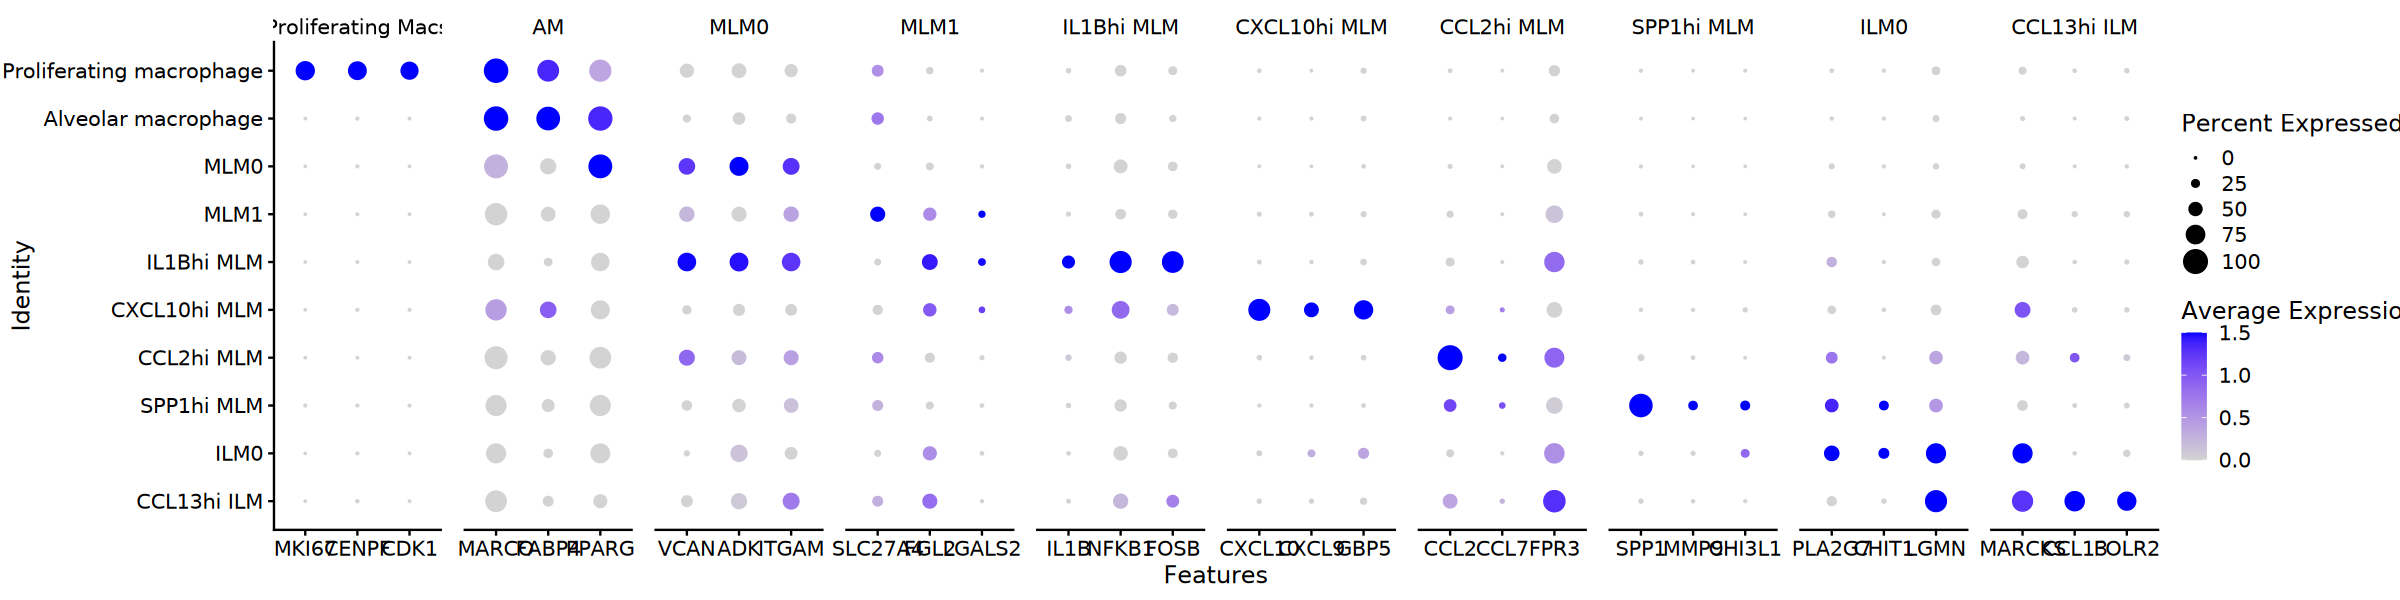

In [4]:
genes <- list("Proliferating Macs" = c("MKI67", "CENPF", "CDK1"),
              "AM" = c("MARCO", "FABP4", "PPARG"),
              "MLM0" = c("VCAN", "ADK", "ITGAM"),
              "MLM1" = c("SLC27A4", "FGL2", "LGALS2"),
              "IL1Bhi MLM" = c("IL1B", "NFKB1", "FOSB"),
              "CXCL10hi MLM" = c("CXCL10", "CXCL9", "GBP5"),
              "CCL2hi MLM" = c("CCL2", "CCL7", "FPR3"),
              "SPP1hi MLM" = c("SPP1", "MMP9", "CHI3L1"),
              "ILM0" = c("PLA2G7", "CHIT1", "LGMN"),
              "CCL13hi ILM" = c("MARCKS", "CCL13", "FOLR2"))

macs <- SetIdent(macs, value = "Cell_Sub_subtype") 
new_level_order <- c("CCL13hi ILM", "ILM0", "SPP1hi MLM", "CCL2hi MLM", "CXCL10hi MLM", "IL1Bhi MLM", "MLM1", "MLM0", "Alveolar macrophage", "Proliferating macrophage")
Idents(macs) <- factor(Idents(macs), levels = new_level_order)

a <- DotPlot(macs, 
             features = genes, 
             cols = c("lightgrey", "blue"), 
             col.min = 0, col.max = 1.5, scale.min = 0, scale.max = 100) 
options(repr.plot.width = 20, repr.plot.height = 5)

print(a)